## Causal Tracing (ROME)

Causal tracing was a methodology for locating where facts are stored in transformer LMs, introduced in the paper ["Locating and Editing Factual Associations in GPT" (Meng et al., 2023)](https://arxiv.org/abs/2202.05262). In this notebook, we will implement their method using this library and replicate the first causal tracing example in the paper (full figure 1 on page 2).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/advance_tutorials/Causal_Tracing.ipynb)

In [1]:
__author__ = "Aryaman Arora"
__version__ = "11/08/2023"

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [3]:
import torch
import pandas as pd
import numpy as np
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention, Intervention,
    RepresentationConfig,
    IntervenableConfig,
    ConstantSourceIntervention,
    LocalistRepresentationIntervention
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    xlab, ylab, ylim,
    scale_y_discrete, scale_y_continuous, ggsave
)
from plotnine.scales import scale_y_reverse, scale_fill_cmap
from tqdm import tqdm

titles={
    "block_output": "single restored layer in GPT2-XL",
    "mlp_activation": "center of interval of 10 patched mlp layer",
    "attention_output": "center of interval of 10 patched attn layer"
}

colors={
    "block_output": "Purples",
    "mlp_activation": "Greens",
    "attention_output": "Reds"
}

### Factual recall

Let's set up the model (gpt2-xl) and test it on the fact we want to causal trace: "The Space Needle is in downtown **Seattle**".

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
config, tokenizer, gpt = create_gpt2(name="gpt2-xl")
gpt.to(device)

# base = "The Space Needle is in downtown"
base = "The capital of Poland is"
inputs = [
    tokenizer(base, return_tensors="pt").to(device),
]
print(base)
res = gpt(**inputs[0])
print(res.last_hidden_state.shape)
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The capital of Poland is
torch.Size([1, 5, 1600])
_Warsaw              0.4265737533569336
_K                   0.06574711948633194
_the                 0.059800442308187485
_now                 0.057192523032426834
_located             0.02612617425620556
_a                   0.02013055793941021
_in                  0.018103165552020073
_also                0.012889989651739597
_G                   0.010741124860942364
_one                 0.01033310778439045


## Corrupted run

The first step in implementing causal tracing is to corrupt the input embeddings for the subject tokens by adding Gaussian noise to them. In Meng et al., the standard deviation of the Gaussian we sample from is computed as thrice the standard deviation of embeddings over a big dataset. We encode this as a constant, `self.noise_level`.

Note that the `source` argument is ignored unlike in causal interventions, since we are adding noise without reference to any other input.

Our intervention config intervenes on the `block_input` of the 0th layer, i.e. the embeddings.

In [5]:
class NoiseIntervention(ConstantSourceIntervention, LocalistRepresentationIntervention):
    def __init__(self, embed_dim, **kwargs):
        super().__init__()
        self.interchange_dim = embed_dim
        rs = np.random.RandomState(1)
        prng = lambda *shape: rs.randn(*shape)
        self.noise = torch.from_numpy(
            prng(1, 4, embed_dim)).to(device)
        self.noise_level = 0.13462981581687927

    def forward(self, base, source=None, subspaces=None):
        base[..., : self.interchange_dim] += self.noise * self.noise_level
        return base

    def __str__(self):
        return f"NoiseIntervention(embed_dim={self.embed_dim})"


def corrupted_config(model_type):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                0,              # layer
                "block_input",  # intervention type
            ),
        ],
        intervention_types=NoiseIntervention,
    )
    return config

Let's check that this reduced the probability of the output "_Seattle".

In [6]:
base = tokenizer("The capital of Poland is", return_tensors="pt").to(device)
config = corrupted_config(type(gpt))
intervenable = IntervenableModel(config, gpt)
_, counterfactual_outputs = intervenable(
    base, unit_locations={"base": ([[[0, 1, 2, 3]]])}
)
distrib = embed_to_distrib(gpt, counterfactual_outputs.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

_a                   0.2006950080394745
_the                 0.11948680132627487
_not                 0.036834534257650375
_an                  0.030864432454109192
_one                 0.022700520232319832
_in                  0.02148324064910412
_to                  0.019450439140200615
_now                 0.012400258332490921
_going               0.007659954018890858
_my                  0.006965573411434889


### Restored run

We now make a config that performs the following:
1. Corrupt input embeddings for some positions.
2. Restore the hidden state at a particular layer for some (potentially different positions).

This is how Meng et al. check where in the model the fact moves through.

In [7]:
def restore_corrupted_with_interval_config(
    layer, stream="mlp_activation", window=10, num_layers=48):
    start = max(0, layer - window // 2)
    end = min(num_layers, layer - (-window // 2))
    config = IntervenableConfig(
        representations=[
            RepresentationConfig(
                0,       # layer
                "block_input",  # intervention type
            ),
        ] + [
            RepresentationConfig(
                i,       # layer
                stream,  # intervention type
        ) for i in range(start, end)],
        intervention_types=\
            [NoiseIntervention]+[VanillaIntervention]*(end-start),
    )
    return config

Now let's run this over all layers and positions! We will corrupt positions 0, 1, 2, 3 ("The Space Needle", i.e. the subject of the fact) and restore at a single position at every layer.

In [8]:
# should finish within 1 min with a standard 12G GPU
token = tokenizer.encode(" Warsaw")[0]
print(token)

32955


In [9]:
len(base.input_ids[0])

5

In [10]:
%mkdir tutorial_data

mkdir: cannot create directory ‘tutorial_data’: File exists


In [11]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    data = []
    for layer_i in tqdm(range(gpt.config.n_layer)):
        for pos_i in range(len(base.input_ids[0])):
            config = restore_corrupted_with_interval_config(
                layer_i, stream,
                window=1 if stream == "block_output" else 10
            )
            n_restores = len(config.representations) - 1
            intervenable = IntervenableModel(config, gpt)
            _, counterfactual_outputs = intervenable(
                base,
                [None] + [base]*n_restores,
                {
                    "sources->base": (
                        [None] + [[[pos_i]]]*n_restores,
                        [[[0, 1, 2, 3]]] + [[[pos_i]]]*n_restores,
                    )
                },
            )
            distrib = embed_to_distrib(
                gpt, counterfactual_outputs.last_hidden_state, logits=False
            )
            prob = distrib[0][-1][token].detach().cpu().item()
            data.append({"layer": layer_i, "pos": pos_i, "prob": prob})
    df = pd.DataFrame(data)
    df.to_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")

100%|██████████| 48/48 [01:24<00:00,  1.76s/it]


The plot below should now replicate Meng et al.

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_block_output.pdf


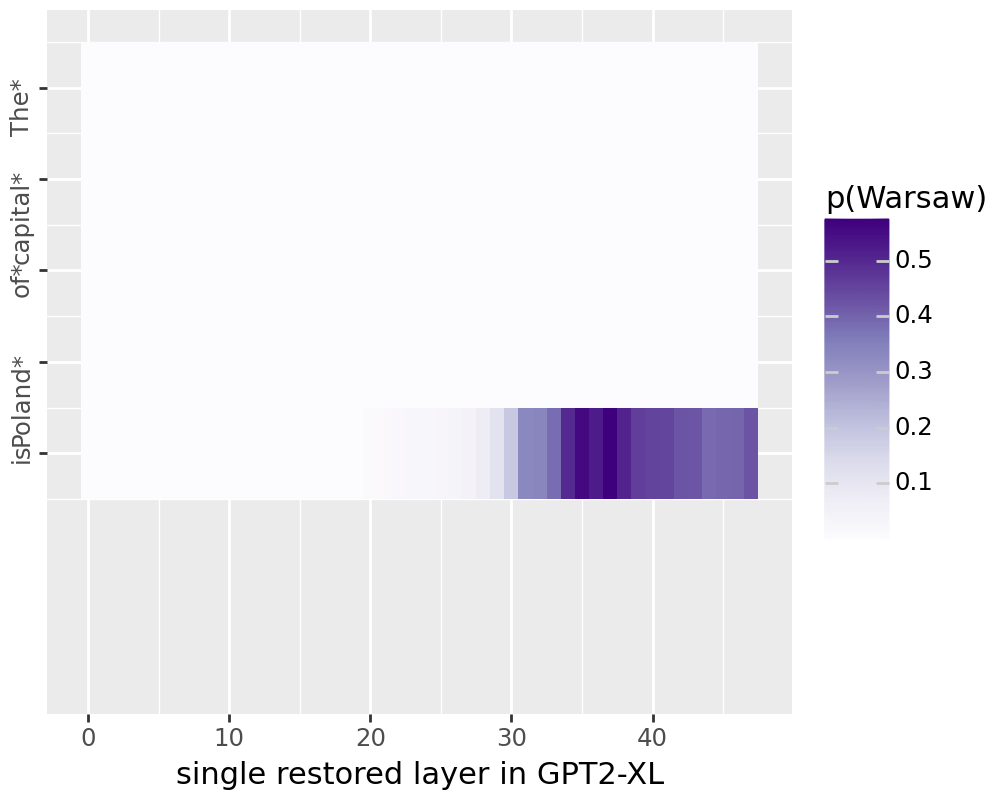

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_mlp_activation.pdf


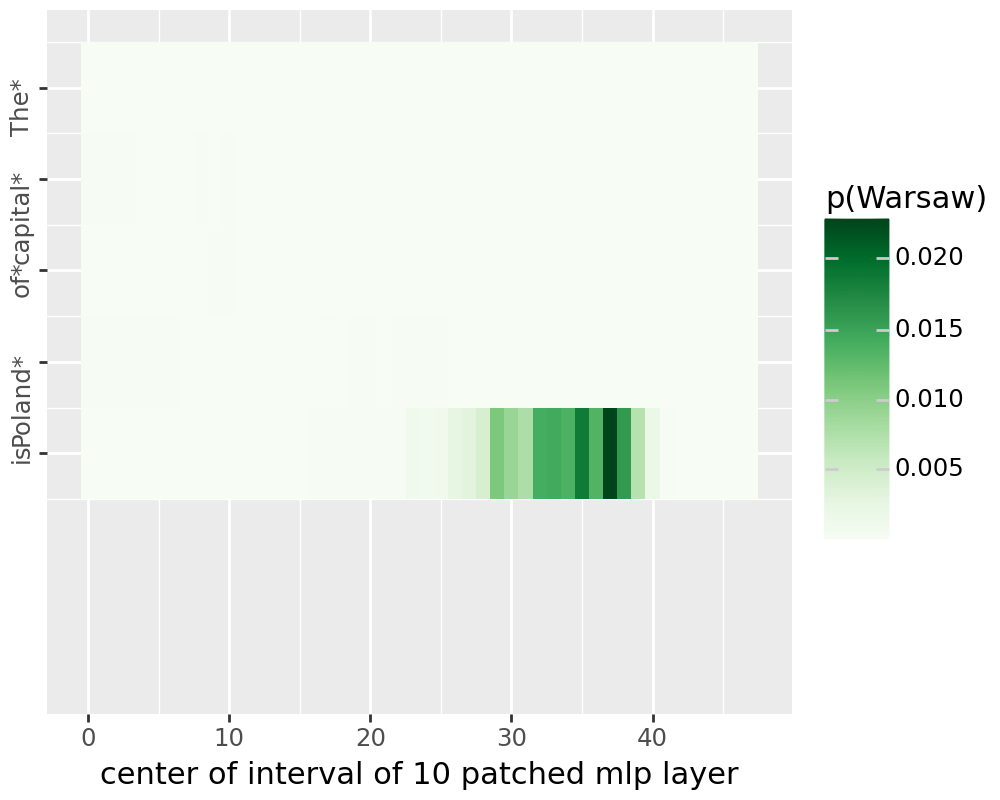

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 4 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./tutorial_data/pyvene_rome_attention_output.pdf


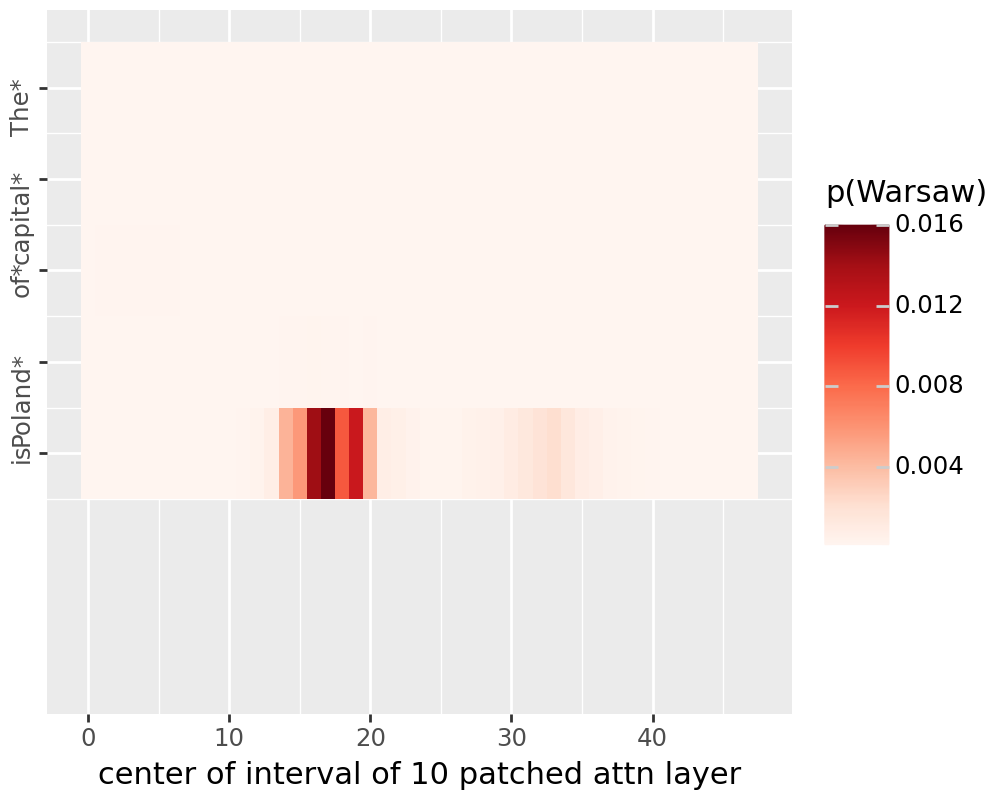

In [16]:
for stream in ["block_output", "mlp_activation", "attention_output"]:
    df = pd.read_csv(f"./tutorial_data/pyvene_rome_{stream}.csv")
    df["layer"] = df["layer"].astype(int)
    df["pos"] = df["pos"].astype(int)
    df["p(Warsaw)"] = df["prob"].astype(float)

    custom_labels = ["The*", "capital*", "of*", "Poland*", "is"]
    breaks = [0, 1, 2, 3, 4]

    plot = (
        ggplot(df, aes(x="layer", y="pos"))

        + geom_tile(aes(fill="p(Warsaw)"))
        + scale_fill_cmap(colors[stream]) + xlab(titles[stream])
        + scale_y_reverse(
            limits = (-0.5, 6.5),
            breaks=breaks, labels=custom_labels)
        + theme(figure_size=(5, 4)) + ylab("")
        + theme(axis_text_y  = element_text(angle = 90, hjust = 1))
    )
    ggsave(
        plot, filename=f"./tutorial_data/pyvene_rome_{stream}.pdf", dpi=200
    )
    display(plot)